# 02_rfm_clustering

## Importando bibliotecas

In [12]:
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Carregando os dados

In [13]:
# Carregando os dados
df = pd.read_csv('../data/raw/data.csv', encoding='ISO-8859-1')

In [14]:
# Visualizando as primeiras linhas
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [15]:
df.shape

(541909, 8)

## Processamento

In [16]:
# Convertendo datas
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Data de referência para cálculo de recência
data_ref = df['InvoiceDate'].max() + pd.Timedelta(days=1)
# Criando TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [17]:
# Cálculo das métricas RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (data_ref - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [18]:
# Padronizando os dados
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

## Determinando número ideal de clusters

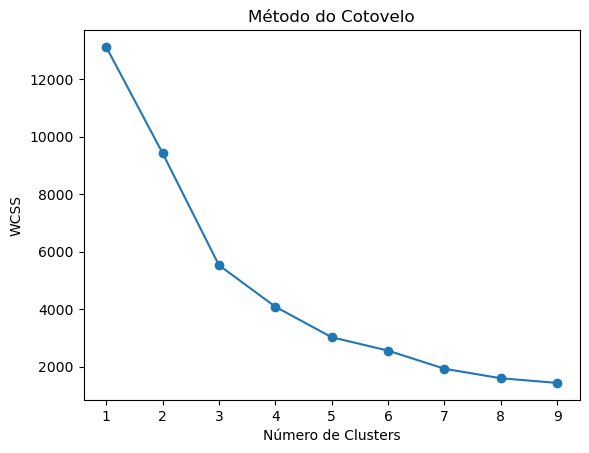

In [19]:
# Determinando número ideal de clusters
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')
plt.show()


## Aplicando KMeans

In [20]:
# Aplicando KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346.0,326,2,0.00,1
1,12347.0,2,7,4310.00,0
2,12348.0,75,4,1797.24,0
3,12349.0,19,1,1757.55,0
4,12350.0,310,1,334.40,1


In [22]:
# Contagem de clientes por cluster
rfm['Cluster'].value_counts()

Cluster
0    3244
1    1105
2      23
Name: count, dtype: int64

In [21]:
# Exportando os dados
rfm.to_csv('../data/processed/rfm.csv', index=False)